In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/home/jj/github/NLP/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.31.0
Using datasets v2.13.1
Using accelerate v0.21.0
Using sentencepiece v0.1.99
Using sacrebleu v2.3.1
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.20.5


In [2]:
# import os
# os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"]="python"

In [3]:
# import os
# print(os.getcwd())
# os.chdir("/home/jj/github/NLP/")

In [4]:
from transformers import pipeline, set_seed

In [5]:
#from tqdm.auto import tqdm

# 요약
요약은 입력과 출력이 텍스트인 고전적인 시퀀스-투-시퀀스(seq-2-seq) 작업이다.  
요약에는 인코더-디코더 트랜스포머가 잘 맞다.

#### 인코더-디코더 모델을 만들어 여러 사람이 주고받은 대화를 간결하게 요약하기 전, 요약에 사용하는 대표적인 데이터셋 CNN/DailyMail 말뭉치를 살펴보자.

# 6.1 CNN/DailyMail 데이터셋

In [6]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(f"특성: {dataset['train'].column_names}")

특성: ['article', 'highlights', 'id']


이 데이터셋은 세 가지 특성이 존재한다.  
뉴스기사를 담은 article, 요약에 해당하는 highlights, 기사의 고유 아이디 id다.

In [8]:
sample = dataset["train"][1]
print(f"""기사 (초반 500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f"\n요약 (길이: {len(sample['highlights'])}):")
print(sample["highlights"])

기사 (초반 500개 문자 발췌, 총 길이: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events. Here,
Soledad O'Brien takes users inside a jail where many of the inmates are mentally
ill. An inmate housed on the "forgotten floor," where many mentally ill inmates
are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the
Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here,
inmates with the most s

요약 (길이: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


기사가 요약에 비해 매우 긴 경우도 존재한다. (해당 예시의 경우 17배나 차이가 난다.)  
대부분 트랜스포머 모델의 문맥크기가 몇 단락에 해당하는 분량인 1,000개 토큰 정도로 제한되므로, 긴 기사는 트랜스포머 모델에 문제를 일으킨다.  
### 이를 처리하는 표준적이면서 가장 단순한 방법은 모델의 문맥 크기에 맞춰 텍스트를 자르는 것이다.
#### 텍스트 끝부분에 중요한 정보가 있다면 사라지겠지만, 이는 모델 구조의 제약으로 생기는 불가피한 선택이다.

# 6.2 텍스트 요약 파이프라인

요약 작업에 많이 사용되는 트랜스포머 모델 몇 가지를 알아보자.  
살펴볼 모델 구조는 최대 입력 크기가 각각 다르지만 동일한 입력을 사용하고 출력을 비교하기 위해 입력 텍스트를 2,000자로 제한하겠다.

In [9]:
sample_text = dataset['train'][1]['article'][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장할 예정.
summaries = {}

#### 요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눈다.  
마침표마다 그 뒤에 줄바꿈 토큰을 추가해도 되지만 그러면 'U.S.'나 'U.N.' 같은 문자열을 처리하지 못한다.  
#### NLTK(Natural Language Toolkit) 패키지에는 문장의 종결과 약어에 등장하는 구두점을 구별하는 더 정교한 알고리즘이 있다.

In [10]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/jj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

## 6.2.1 요약 기준 모델
기사를 요약하는 일반적인 기준 모델(baseline)은 단순히 기사에서 맨 처음 문장 세 개를 선택하는 것이다. 이런 기준 모델은 NLTK 문장 토크나이저로 쉽게 구현할 수 있다.

In [12]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [13]:
summaries["baseline"] = three_sentence_summary(sample_text)

## 6.2.2 GPT-2

gpt-2 모델은 입력 텍스트 뒤에 'TL;DR'을 추가해 요약을 생성하는 기능이 있다.  
(TL;DR -> Toll long; didn't read (너무 길어 읽지 않았다)는 문구의 약어)  
"TL;DR"은 레딧 같은 사이트에서 긴 포스트를 짧게 요약할 때 종종 사용된다.

트랜스포머스의 pipeline() 함수로 원본 논문의 방식을 재현하며 요약 작업을 실험해보자.  
#### 텍스트 생성 파이프라인을 만들고 대용량 GPT-2 모델을 로드한다.

In [14]:
from transformers import pipeline, set_seed

set_seed(42)

In [15]:
# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.

pipe = pipeline("text-generation", model="gpt2-large")

In [16]:
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces = True)
summaries['gpt2'] = "\n".join(
    sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query) :]))

나중의 비교를 위해 출력에서 입력 텍스트의 다음 부분을 요약으로 추출해 파이썬 딕셔너리에 저장한다.

## 6.2.3 T5

T5의 개발자들은 NLP에서 포괄적인 전이 학습 연구를 수행해 모든 작업을 텍스트-투-텍스트 작업으로 구성하는 범용의 트랜스포머 아키텍처를 만들었다.  
T5 체크포인트는 요약을 포함해 여러 작업에서 (마스킹된 단어를 재구성하기 위한) 비지도 학습 데이터와 지도 학습 데이터를 섞은 데이터로 훈련됐다.  
따라서 미세 튜닝 없이 이 체크포인트를 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 바로 요약에 사용할 수 있다.

문서 요약에 사용할 모델의 입력 포맷은 "summarize: \<Article>"이고, 번역에 사용할 입력 포맷은 "translate English to German: \<TEXT>"다.  
T5의 텍스트-투-텍스트 프레임워크에는 '번역'과 '요약' 작업 말고도 'CoLA(linguistic acceptability)'와 'STSB(semantic similarity)' 작업이 있다.

#### 요약을 위해 pipeline() 함수로 T5를 로드한다.
이 함수는 입력을 텍스트-투-텍스트 포맷으로 처리하므로 앞에 "summarize"를 붙일 필요가 없다.

In [17]:
pipe = pipeline("summarization", model="t5-large") # 책에서는 't5-large'사용
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## 6.2.4 BART

BART도 인코더-디코더를 사용하는 모델로, 손상된 입력을 재구성하도록 훈련됐다.  
#### 이를 위해 BERT와 GPT-2의 사전 훈련 방식을 결합한다.
여기서는 특별히 CNN/DailyMail 데이터셋에 미세 튜닝된 facebook/bart-large-ccn 체크포인트를 사용한다.

In [18]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

## 6.2.5 PEGASUS

PEGASUS는 BART와 마찬가지로 인코더-디코더 트랜스포머다.  
이 모델은 여러 문장으로 구성된 텍스트에서 마스킹된 문장을 예측하는 사전 훈련 목표로 훈련됐다.  
논문의 저자들은 사전 훈련 목표가 후속 작업에 가까울수록 더 효과적이라고 주장한다.  
#### 일반적인 언어 모델링보다 요약에 특화된 사전 훈련 목표를 찾기 위해 대규모 말뭉치에서( 내용 중복을 측정하는 요약 평가 지표를 사용해) 주변 문단의 내용을 대부분 담은 문장을 자동으로 식별했다.
이런 문장을 재구성하도록 PEGASUS 모델을 사전 훈련해 최고 수준의 텍스트 요약 모델을 얻었다.

In [19]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")

In [20]:
pipe_out = pipe(sample_text)
# 이 모델은 줄바꿈하는 특수 토큰이 있으므로 sent_tokenize() 함수를 사용할 필요가 없다.
summaries['pegasus'] = pipe_out[0]['summary_text'].replace(" .<n>", ".\n")

# 6.3 요약 결과 비교하기
가장 처음의 GPT-2 모델은 데이터셋에서 전혀 훈련되지 않았다는 점을 기억해둘 것.  
T5 모델은 여러 작업 중의 하나로 이 작업을 위해 미세 튜닝됐다.  
BART와 PEGASUS 두 모델은 이 작업만을 위해 미세튜닝 됐다.

#### 네 모델이 생성한 요약결과 확인

In [21]:
print("GROUND TRUTH")
print(dataset['train'][1]['highlights'])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their
experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are
mentally ill. An inmate housed on the "forgotten floor," where many mentally ill
inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention
facility is dubbed the "forgotten floor."

GPT2
-- We visited the jail where mentally ill people are locked up and did an
investigation on what jailers really think about the mentally ill
-- Mentally ill people end up in the court system and are often imprisoned on


이제 제품환경에 어떤 모델을 사용할지 결정해보자.  
#### 지표를 하나 정의하고 특정 벤치마크 데이터셋에서 모든 모델을 평가해서 성능이 최고인 모델을 선택하는 것이 이상적인 방법이다.
하지만 어떤 평가지표를 써야할까 -> 정확도, 재현율, 정밀도 같은 표준 지표는 이 작업에 적용하기 쉽지않다.

# 6.4 생성된 텍스트 품질 평가하기
평가 지표 -> 모델을 훈련할 때만이 아니라 나중에 제품 환경에서도 모델 성능을 평가하기 때문에 중요.  
평가 지표가 나쁘면 모델의 성능 저하를 눈치 채지 못하고, 평가 지표가 비즈니스 목표에 맞지 않으면 어떤 가치도 창출하지 못함.

### 생성된 텍스트를 평가하는데 가장 널리 사용되는 두 지표는 BLEU와 ROUGE다.

## 6.4.1 BLEU
https://oreil.ly/nMXRh 에서는 BLEU의 단점을 잘 설명해두었다.  
BLEU-4 score가 많이 쓰이며, 토큰화 단계를 내재화한 SacreBLEU가 벤치마킹에서 선호되는 지표다.

In [22]:
from datasets import load_metric
bleu_metric = load_metric("sacrebleu")

/tmp/ipykernel_7673/3482725883.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


bleu_metric 객체는 Metric 클래스의 인스턴스로 하나의 수집기(aggregator)처럼 작동한다.  
add() 메서드에 샘플 하나를 추가하거나 add_batch() 메서드로 배치 전체를 추가한다.  
평가하려는 샘플을 모두 추가한 다음 compute() 메서드를 호출하면 지표가 계산된다.

이 메서드는 몇 개의 값으로 구성된 딕셔너리를 반환한다.  
(각 n-gram에 대한 정밀도, 길이 페널티, 최종 BLEU 점수 등)

In [23]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


BLEU 점수는 여러 참조 번역이 있는 경우에도 계산된다.  
이 때문에 reference 매개변수에 리스트를 전달한다.  
BLEU는 정밀도 계산을 조금 바꿔 n-gram이 하나도 없을 때 최종점수가 0이 되는 경우를 방지한다.  
이를 위한 방법으로 분자에 상수 값을 추가한다.  
이렇게 하면 n-gram이 없어도 점수가 0이되지 않는다. (이 값을 설명하기 위해 smooth_value=0로 지정해 해당 기능을 껐다.)

※ smooth_method가 'floor'이면 smooth_value의 기본값이 0.1이고, n-gram이 없을 경우 분자로 0.1을 사용한다.  
smoot_method가 'add-k'이면 smooth_value의 기본값이 1이고, n-gram이 없을 경우 분모와 분자에 1이 더해진다.  
smooth_method의 기본값은 'exp'이며 smooth_value를 사용하지 않고, n-gram이 없을 때마다 2의 거듭제곱을 누적해 분모에 곱한 역수를 계산한다.

### 1-gram의 정밀도는 실제로 2/6이다. 반면 2/3/4-gram의 정밀도는 모두 0이다.
### 따라서 기하 평균이 0이 되므로 BLEU 점수도 0이 된다.

(counts와 bp 같은 개별 지표의 자세한 내용은 SacreBLEU 저장소 https://oreil.ly/kiZPl 를 참고)

In [24]:
# 정밀도가 높은 예시

bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


예측에 있는 1-gram은 모두 맞지만 다른 정밀도 점수를 보면 틀린 예측도 있음을 알 수 있다.  
4-gram은 ["the", "cat", "is", "on"]과 ["cat", "is", "on", "mat"] 두 개다.  
두 번째를 맞추지 못했으므로 4-gram 정밀도는 0.5가 된다.

### BLEU 점수는 텍스트 평가에 널리 사용된다.  
### 가능하고 적합한 단어를 모두 포함하는 번역보다 정확한 번역이 선호되기 때문에 특히 기계 번역에 많이 쓰인다.

이와 상황이 다른 요약 같은 애플리케이션이 있다.  
이때는 중요한 정보가 생성된 텍스트에 모두 포함되어야 하므로 높은 재현율이 선호된다.
이런 작업에는 주로 ROUGE가 사용된다.

## 6.4.2 ROUGE

데이터셋 구현은 두 종류의 ROUGE 점수를 계산한다.  
하나는 문장마다 점수를 계산해서 요약에 대해 평균한 점수(ROUGE-L)이고,  
다른 하나는 전체 요약에 대해 계산한 점수(ROUGE-Lsum)이다.

이 측정 지표는 이렇게 로드한다.

In [25]:
rouge_metric = load_metric("rouge")

위에서 여러 모델의 요약을 이미 생성했으니 이 지표로 요약을 비교해보자.  
모델이 생성한 모든 요약에 ROUGE 점수를 적용한다.

In [26]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.260870,0.053097,0.156522,0.260870
t5,0.382979,0.130435,0.255319,0.382979
bart,0.475248,0.222222,0.316832,0.415842
pegasus,0.323232,0.206186,0.282828,0.323232


데이터셋에 있는 ROUGE 지표는 신뢰구간 confidence interval(기본적으로 백분위수 9와 95 사이)도 계산한다.  
mid 속성에 중앙값이 저장되고 low와 high 속성으로 구간의 양 끝 값을 추출한다.

단일 샘플만 보았으므로 이 결과를 크게 신뢰하기는 어렵지만, 한 샘플에 대한 요약 품질을 비교할 수 있다.  
이 표에서 GPT-2의 성능이 가장 낮다. 이 모델만 요약을 위해 명시적으로 훈련되지 않았으니 그럴 만하다.  
놀라운 부분은 처음 세 문장을 요약으로 사용한 간단한 기준 모델이 파라미터가 약 10억 개인 트랜스포머 모델에 비해 그다지 뒤떨어 지지 않는다는 점이다.  
#### ROUGE 점수가 높을수록 좋다. 해당 결과에서는 bart가 가장 좋게 나왔다.

# 6.5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

In [27]:
# 이 셀은 노트북 중간부터 실행하기 위한 것.
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용
dataset = load_dataset("cnn_dailymail", version='3.0.0')
rouge_metric = load_metric("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

  0%|          | 0/3 [00:00<?, ?it/s]

#### 처음 세 문장을 사용하는 기준 모델의 성능부터 평가

In [28]:
def evaluate_summaries_baseline(dataset, metric,
                               column_text="article",
                               column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                    references=dataset[column_summary])
    score = metric.compute()
    return score

데이터셋의 테스트 세트는 대략 10,000개의 샘플로 구성되었다.  
생성되는 모든 토큰이 모델의 정방향 패스를 거쳐야하며, 샘플마다 100개 토큰을 생성하기 위해 필요한 정방향 패스의 횟수는 백만 번이다.  
빔 서치를 사용할 경우 이 수치에 빔 크기를 곱해야 한다.  
계산을 빠르게 마치기 위해 테스트 세트에서 1,000개를 샘플링해 평가해보자.  

In [29]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient='index', columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


#### 이제 PEGASUS 모델을 평가할 함수를 구현해보자.

In [30]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                              batch_size=16, device=device,
                              column_text="article",
                              column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,
                          padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs['input_ids'].to(device),
                                  attention_mask=inputs['attention_mask'].to(device),
                                  length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                             clean_up_tokenization_spaces=True)
                            for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    
    score = metric.compute()
    return score    

1) 먼저 데이터셋을 동시에 처리하기 위해 작은 배치로 나눔
2) 그다음 각 배치의 입력 샘플을 토큰화하고 generate() 함수에 전달해 빔 서치로 요약을 생성. (논문에 언급된 것과 동일한 생성 매개변수 사용)
3) 길이 패널티 매개변수는 모델이 매우 긴 시퀀스를 생성하지 않도록 한다.
4) 마지막으로 생성된 텍스트를 디코딩하고, \<n> 토큰을 공백으로 바꾸고, 디코딩된 토큰과 참조 텍스트를 지표에 추가한다.
5) 마침내 ROUGE 점수를 계산하고 반환한다.

In [31]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [32]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [33]:
# score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
#                                    model, tokenizer, batch_size=4)
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=["pegasus"])

#### 중요한 점은 손실과 각 토큰의 정확도가 ROUGE 점수와 일정 수준 관련성이 없다는 것이다.  
#### 손실은 디코딩 전략과 관련이 없지만, ROUGE 점수는 디코딩 전략과 밀접하게 관련된다.

ROUGE와 BLEU가 손실이나 정확도보다 사람의 판단과 더 밀접하므로 여기에 초점을 맞추고 텍스트 생성 모델을 만들 때 디코딩 전략을 주의 깊게 탐색하고 선택해야 한다.  
하지만 이런 지표가 완벽하지는 않으므로 항상 사람의 판단도 고려할 필요가 있다.

#### 평가 함수를 마련했으니, 이제 요약을 위한 모델을 직접 훈련해보자.

# 6.6 요약 모델 훈련하기

삼성이 만든 SAMSum 데이터셋 사용.  
https://oreil.ly/n1ggq  
이 데이터셋은 대화와 이에 대한 짧은 요약으로 구성된다.

기업에서 이런 대화는 고객과 지원 센터의 상호작용을 나타낸다.  
따라서 정확한 요약을 생성하면 고객 서비스를 개선하고 고객 요청에 나타난 보편적인 패턴을 감지할 수 있다.  

In [34]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

  0%|          | 0/3 [00:00<?, ?it/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


In [35]:
dataset_samsum

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

해당 대화에는 이모지와 GIF를 위한 플레이스홀더(placeholder)가 포함됐다.  
dialogue 필드는 전체 텍스트를 담고 있고 summary는 대화의 요약이다.
#### CNN/DailyMail 데이터셋에서 미세 튜닝한 모델이 같은 작업을 수행할 수 있을지 알아보자

## 6.6.1 SAMSum에서 PEGASUS 평가하기
#### 먼저 PEGASUS로 요약 파이프라인을 실행하여 어떻게 출력하는지 보자.

In [36]:
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


모델이 대화에서 핵심 문장을 추출해 요약하려는 것 같다.  
CNN/DailyMail 데이터셋에는 비교적 잘 맞았겠지만 SAMSum의 요약은 더 추상적이다.  
#### 테스트 세트에서 ROUGE 평가를 수행해 이를 확인해보자.

In [37]:
# score = evaluate_summaries_pegasus(dataset_samsum['test'], rouge_metric,
#                                    model, tokenizer, column_text="dialogue",
#                                   column_summary="summary", batch_size=4)
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=["pegasus"])

결과가 좋지는 않지만, CNN/DailyMail 데이터셋이 SAMSum과 크게 다르기 떄문에 어느 정도 예상할만한 결과다.

#### 훈련 전에 평가 파이프라인을 준비하면 두 가지 이점이 있다.
### 훈련이 성공적인지 바로 평가가 가능해졌고 기준점이 세워진 것이다.

이 데이터셋에서 모델을 미세튜닝하면 ROUGE 점수가 바로 향상되어야 한다.  
그렇지 않으면 훈련 과정에 문제가 있는 것이다.

## 6.6.2 PEGASUS 미세 튜닝하기

훈련을 위해 데이터를 처리하기 전, 입력과 출력 길이의 분포를 간단히 살펴보자.

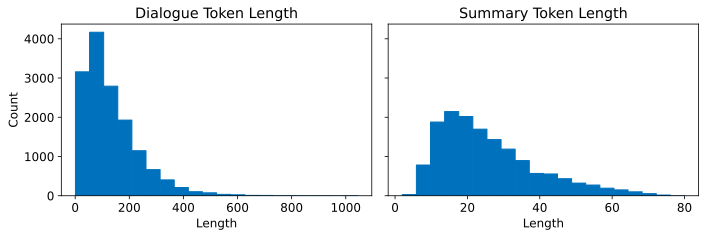

In [38]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]['summary']]

# sharey=True: 여러개의 하위 플롯 간에 X축과 Y축을 공유
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

대부분의 대화는 100\~200개 토큰으로 구성되며 CNN/DailyMail 기사보다 훨씬 더 짧다.  
마찬가지로 요약도 20~40개 토큰(평균 트윗 길이)로 구성되며 훨씬 더 짧다.

#### 이런 점을 유념하면서 Trainer를 위한 데이터 콜레이터를 만들어보자.  
먼저 데이터셋을 토큰화한다.  
여기서는 대화와 요약의 최대길이를 각각 1024와 128로 설정한다.

In [39]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                               truncation=True) # truncation=True : 문장 잘림을 허용
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                    truncation=True)
    
    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}

In [40]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                      batched=True) # batched=True: 적용되는 함수가 배치형태로 처리가 가능한 함수인 경우에 체크. 멀티 쓰레딩을 사용해 텍스트 데이터를 배치 형태로 빠르게 처리할 수 있습니다.
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

토큰화 단계에 새롭게 적용한 것 -> tokenizer.as_target_tokenizer()  
일부 모델은 디코더 입력에 특수 토큰이 필요하다.  
따라서 인코더와 디코더 입력의 토큰화를 구별하는 것이 중요하다.

#### 컨텍스트 매니저 (context manager)라 부르는 with 문을 사용하면 토크나이저가 디코더를 위한 토큰화임을 인지하고 그에 따라 시퀀스를 처리할 수 있다.

### 이제 데이터 콜레이터를 만들어 보자. (데이터 콜레이터는 샘플 목록을 가져와 일괄 처리로 변환하는 함수)
이 함수는 배치를 모델에 주입하기 전에 Trainer에 의해 호출된다.  
대부분의 경우 단순히 배치에 있는 모든 텐서를 가져와 쌓는 기본 콜레이터를 사용한다.  
#### 요약 작업에서는 입력을 쌓을 뿐만 아니라 디코더 쪽의 타깃도 준비한다.  
PEGASUS는 인코더-디코더 트랜스포머이고, 따라서 고전적인 seq2seq 구조를 취한다.  
seq2seq 구조에서는 디코더에 '티처 포싱 teacher forcing'을 적용하는 것이 일반적이다.  
  
(teacher forcing: 디코더의 다음 타임스텝에 입력값으로, 이전 타임스텝의 결과값이 아닌 정답값을 넣어 학습하는 형태)  
이 전략에서는 (GPT-2 등의 디코더 전용 모델처럼) 디코더가 인코더 출력 외에 한 토큰이 이동된 레이블로 구성된 입력 토큰을 받는다.  
따라서 아래 표처럼 다음 토큰을 위한 예측을 만들 때 디코더는 한 토큰이 이동된 정답을 입력으로 받는다.

In [41]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1): # 이러면 i가 text의 index
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


한 스텝 이동했으므로 디코더는 이전 스텝의 정답 레이블만 보며 현재와 미래의 레이블을 보지 못한다.  
디코더는 현재와 미래의 모든 입력을 마스킹하는 마스크드 셀프 어텐션을 갖기 때문에 이동시키는 것으로 충분하다.

따라서 배치를 준비할 때 레이블을 한 스텝 오른쪽으로 이동시켜 디코더 입력을 만든다.  
그런 다음 레이블에 있는 패딩 토큰을 -100으로 설정해 손실 함수가 무시하도록 만든다.  
그러나 DataCollatorForSeq2Seq에서 이런 작업을 모두 처리하므로 실제로 이를 수동으로 할 필요는 없다.

In [42]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#### 이제 이전처럼 훈련을 위해 TrainingArguments를 설정한다.

In [43]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=512)

이전과 달리 새 매개변수 gradient_accumulation_steps가 추가됐다.  
#### 모델이 매우 크니 배치 크기를 1로 지정하는데, 배치 크기가 너무 작으면 수렴하지 않는다.  
#### 이 문제를 해결하기 위해 그레디언트 누적(gradient accumulation)이라는 기술을 사용한다.
이름 그대로 큰 배치의 그레디언트를 한 번에 계산하는 대신 작은 배치를 만들고 그레디언트를 누적하는 방식이다.  
그레디언트가 충분히 누적되면 최적화 단계가 수행된다.  
### 당연히 한 번에 실행하는 것보다 조금 더 느리지만 GPU 메모리가 많이 절약된다.

In [44]:
# from huggingface_hub import notebook_login

# notebook_login()

In [45]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [46]:
trainer = Trainer(model=model, args=training_args,
                 tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                 train_dataset=dataset_samsum_pt["train"],
                 eval_dataset=dataset_samsum_pt["validation"])

/home/jj/github/NLP/nlp-with-transformers/pegasus-samsum is already a clone of https://huggingface.co/bh8648/pegasus-samsum. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

In [ ]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=1, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

훈련 루프의 일부로 생성된 텍스트를 평가할 수도 있다.  
Seq2SeqTrainingArguments란 이름의 TrainingArguments의 확장을 사용하고 predict_with_generate=True를 지정한다.  
이를 Seq2SeqTrainer란 이름의 전용 Trainer에 전달한다.  
그러면 평가를 위해 모델의 정방향 패스가 아니라 generate() 함수를 사용해 예측을 만든다.  
한 번 실험해 볼 것

In [ ]:
trainer.push_to_hub("Training complete!")

## 6.6.3 대화 요약 생성하기

테스트 세트에 있는 샘플로 어떤 요약이 만들어지는지 확인

In [1]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `bh8648`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="bh8648/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

진짜 테스흐 -> 실제 대화 입력에서 이 모델이 얼마나 잘 동작할까?

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

# 6.7 결론

텍스트 요약은 감성 분석, 개체명 인식, 질문 답변과 같이 분류 작업으로 구성되는 작업에 비해 특수한 어려움이 몇가지 있다.  
정확도 같은 전통적인 지표는 텍스트의 품질을 반영하지 못한다.  
이 장에서 보았듯이 BLEU와 ROUGE 지표가 생성된 텍스트를 더 잘 평가한다.  
하지만 여전히 사람의 판단이 가장 좋은 척도다.

요약 모델로 작업할 때는 주로 모델의 문맥 크기보다 긴 텍스트를 어떻게 요약할지에 의문이 생긴다.  
안타깝게도 이 문제를 해결할 수 있는 단일 전략은 없다.  
아직까지도 활발하게 연구되고 있는 미결의 문제다.  
OpenAI에서는 긴 문서에 반복적으로 모델을 적용하고 사람의 피드백을 반복 루프에 추가해 요약 작업의 스케일을 확장했다.

In [46]:
torch.cuda.memory_allocated()

10063297536

In [47]:
torch.cuda.memory_reserved() 

11291066368

In [48]:
torch.cuda.empty_cache() # torch.cuda.empty_cache()는 torch.cuda.memory_reserved() 에서 보이는 만큼을 free하게 해줍니다

In [49]:
from numba import cuda

a = cuda.get_current_device()

In [64]:
print(a)

<CUDA device 0 'b'NVIDIA GeForce GTX 1080 Ti''>


In [50]:
a.reset()